In [1]:
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
np.seterr(all='ignore')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import mysql.connector
import psycopg2
pd.options.mode.chained_assignment = None
from IPython.display import display, Markdown, HTML

display(Markdown(f"### Letztes Update: {date.today()}"))

### Letztes Update: 2023-07-13

In [2]:
import bamboolib as bam

In [3]:
mysql_db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo",
    charset="latin1"
)


postgres_db = psycopg2.connect(
    database='kratos',
    host='localhost',
    user='serlo',
    password='secret')


def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(db, sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(mysql_db, sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

In [4]:
df_raw = pd.read_sql( 
     '''
     select user.username as edit_user, event_log.uuid_id as edit_uuid, event_log.date as edit_date, 
     event_log.event_id as edit_event_id, event_parameter_uuid.uuid_id as content_uuid, 
     e.date as content_date, e.event_id as content_event_id, u.username as content_user
     from event_log 
     left join user on user.id = event_log.actor_id
     left join event_parameter on event_parameter.log_id = event_log.id
     left join event_parameter_uuid on event_parameter.id = event_parameter_uuid.event_parameter_id
     left join event_log e on event_parameter_uuid.uuid_id = e.uuid_id
     left join user u on e.actor_id = u.id
     where (event_log.event_id = 5 and e.event_id = 4) or event_log.event_id = 4
     ''', mysql_db
     )

# and year(event_log.date) > 2018 and user.username != "Legacy"

In [6]:
194936 - 148020 # Datenvalidierung :)

46916

In [50]:
import pandas as pd; import numpy as np
df_raw['content_uuid'] = df_raw['content_uuid'].astype('Int64')
df_raw['content_uuid'].fillna(df_raw['edit_uuid'], inplace=True)
df_raw['content_date'].fillna(df_raw['edit_date'], inplace=True)
df_raw['content_user'].fillna(df_raw['edit_user'], inplace=True)

In [8]:
interest_df = pd.DataFrame(query(postgres_db, "SELECT traits ->> 'username', traits ->> 'interest' FROM identities;"), columns=['username', 'interest'])

In [9]:
df_merged = pd.merge(df_raw, interest_df, left_on="edit_user", right_on="username").rename(columns={'interest': 'edit_user_interest'})
df_merged = pd.merge(df_merged, interest_df, left_on="content_user", right_on="username").rename(columns={'interest': 'content_user_interest'})
df_merged = df_merged.drop(["username_x", "username_y"], axis=1)
df_merged["subject"] = df_merged["content_uuid"].map(getSubjectFromUuid)

In [10]:
df = df_merged.copy()
df['collaboration'] = np.where(df['edit_user'] == df['content_user'], 'no', 'yes')

# 1. Betrachtung über alle Bearbeitungen pro Zeiteinheit. Durchschnittliche Anzahl Autorys pro Inhalt.

In [11]:
def get_average_number_of_authors_per_content(date=datetime.today(), timedelta=None):
    df_1 = df.copy()
    if timedelta:
        df_1 = df[(df["edit_date"] >= date - pd.Timedelta(days=timedelta)) & (df["edit_date"] <= date)]  
    df_1 = df_1.groupby('content_uuid')["edit_user"].nunique().mean()
    
    return df_1

In [12]:
def make_collaboration_plot(timedelta=90, freq="w"):
    time_index = pd.date_range(start=df["edit_date"].min(), end=df["edit_date"].max(), freq=freq)

    fig = px.line(x=time_index,
                         y= 
                             [get_average_number_of_authors_per_content(date=t, timedelta=timedelta) 
                              for t in time_index]
                         ,
                         title="title")
    fig.update_layout(title={'text': f"Durchschnittliche Anzahl Autorys pro Inhalt / letzte {timedelta} Tage",
                                 'x':0.5},
                        plot_bgcolor='#ECF2FF', 
                         paper_bgcolor='#ECF2FF', 
                         height=400, width=1000,
                         legend_title = None,
                        xaxis_title=None,
                         yaxis_title=None)
    fig.update_yaxes(range=[0, None])

    fig.show(renderer="png")

In [18]:
def make_histogram(date=datetime.today(), timedelta=None):
    df_1 = df.copy()
    
    if timedelta:
        df_1 = df[(df["edit_date"] >= date - pd.Timedelta(days=timedelta)) & (df["edit_date"] <= date)]
    df_1 = df_1.groupby(['content_uuid']).agg(edit_user_nunique=('edit_user', 'nunique')).reset_index()
    
    fig = px.histogram(df_1, x='edit_user_nunique')
    if timedelta != None:
        fig.update_xaxes(title_text=f'Anzahl unterschiedlicher Autoren pro Inhalt in den letzten {timedelta} Tagen')
    else:
        fig.update_xaxes(title_text=f'Anzahl unterschiedlicher Autoren pro Inhalt / komplette Zeit')
    fig.update_yaxes(title_text='Anzahl bearbeiteter Inhalte')
    fig.show(renderer="png")
    

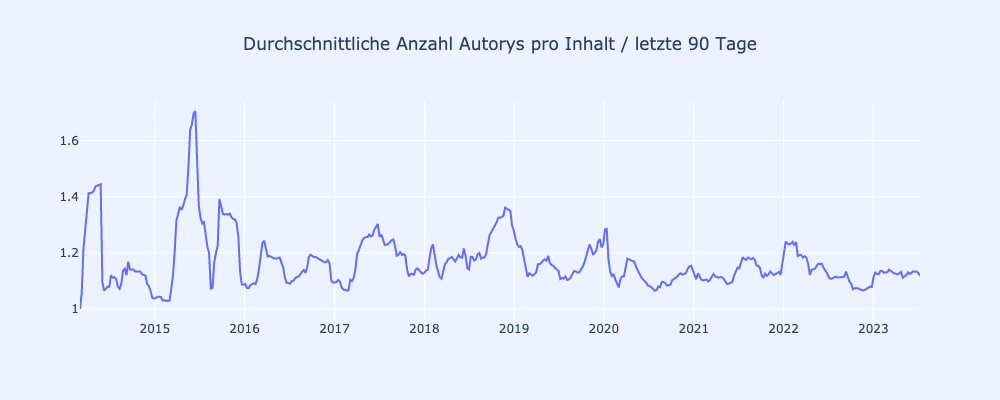

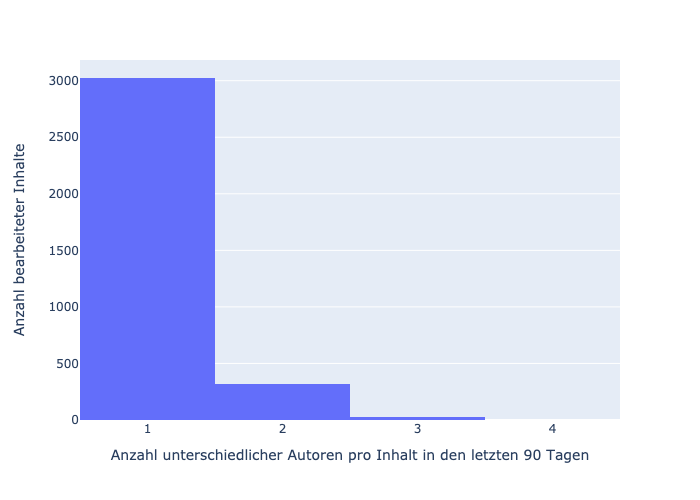

## Durchschnittliche Anzahl Autorys pro Inhalt in den letzten 90 Tagen:

## 1.11

## Vor einem Jahr:

## 1.11

## Durchschnittliche Anzahl Autorys aller Inhalte:

## 2.06

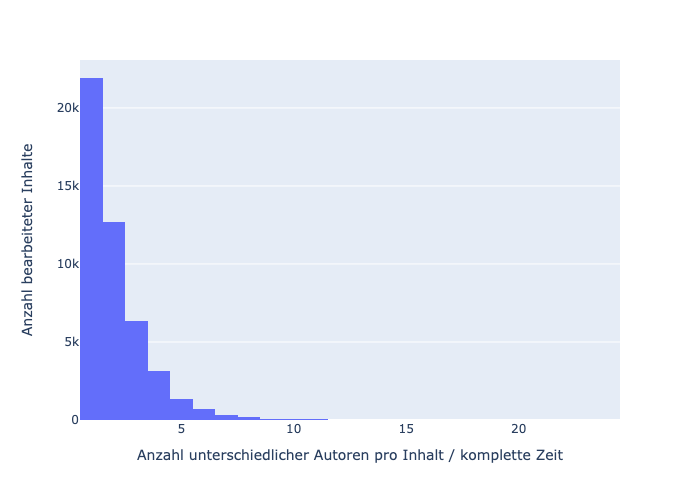

In [19]:
# make_collaboration_plot(timedelta=90, freq="90D")
make_collaboration_plot(timedelta=90)
# make_collaboration_plot(timedelta=180)
# make_collaboration_plot(timedelta=780)
make_histogram(timedelta=90)
display(Markdown("## Durchschnittliche Anzahl Autorys pro Inhalt in den letzten 90 Tagen:"))
display(Markdown(f"## {round(get_average_number_of_authors_per_content(timedelta=90), 2)}"))
display(Markdown("## Vor einem Jahr:"))
display(Markdown(f"## {round(get_average_number_of_authors_per_content(date = datetime.today() - timedelta(days=365), timedelta=90), 2)}"))
display(Markdown("## Durchschnittliche Anzahl Autorys aller Inhalte:"))
display(Markdown(f"## {round(get_average_number_of_authors_per_content(), 2)}"))
make_histogram()

# 2. Betrachtung über alle erstellten Inhalte pro Zeiteinheit. Wie viele verschiedene Autorys in den ersten 90 Tagen nach Inhaltserstellung?

In [35]:
def get_average_number_of_authors_per_content_in_first_days(date=datetime.today(), delta=None):
    df_1 = df.copy()
    if delta:
        df_1 = df[(df["content_date"] >= date - pd.Timedelta(days=delta)) & (df["content_date"] <= date)]
        df_1 = df_1.loc[df_1['edit_date'] <= df_1['content_date'] + timedelta(days=delta)]
    df_1 = df_1.groupby('content_uuid')["edit_user"].nunique().mean()
    
    return df_1

In [36]:
def make_collaboration_plot_contents(delta=90, freq="w"):
    time_index = pd.date_range(start=df["edit_date"].min(), end=df["edit_date"].max(), freq=freq)

    fig = px.line(x=time_index,
                         y= 
                             [get_average_number_of_authors_per_content_in_first_days(date=t, delta=delta) 
                              for t in time_index]
                         ,
                         title="title")
    fig.update_layout(title={'text': f"Durchschnittliche Anzahl Autorys pro Inhalt / letzte {delta} Tage",
                                 'x':0.5},
                        plot_bgcolor='#ECF2FF', 
                         paper_bgcolor='#ECF2FF', 
                         height=400, width=1000,
                         legend_title = None,
                        xaxis_title=None,
                         yaxis_title=None)
    fig.update_yaxes(range=[0, None])

    fig.show(renderer="png")

In [40]:
def make_histogram_contents(date=datetime.today(), delta=None):
    df_1 = df.copy()
    
    if delta:
        df_1 = df[(df["content_date"] >= date - pd.Timedelta(days=delta)) & (df["content_date"] <= date)]
        df_1 = df_1.loc[df_1['edit_date'] <= df_1['content_date'] + timedelta(days=delta)]
    
    # if timedelta:
    #    df_1 = df[(df["edit_date"] >= date - pd.Timedelta(days=timedelta)) & (df["edit_date"] <= date)]
    
    df_1 = df_1.groupby(['content_uuid']).agg(edit_user_nunique=('edit_user', 'nunique')).reset_index()
    
    fig = px.histogram(df_1, x='edit_user_nunique')
    if timedelta != None:
        fig.update_xaxes(title_text=f'Anzahl unterschiedlicher Autoren pro Inhalt in den letzten {delta} Tagen')
    else:
        fig.update_xaxes(title_text=f'Anzahl unterschiedlicher Autoren pro Inhalt / komplette Zeit')
    fig.update_yaxes(title_text='Anzahl erstellter Inhalte')
    fig.show(renderer="png")
    

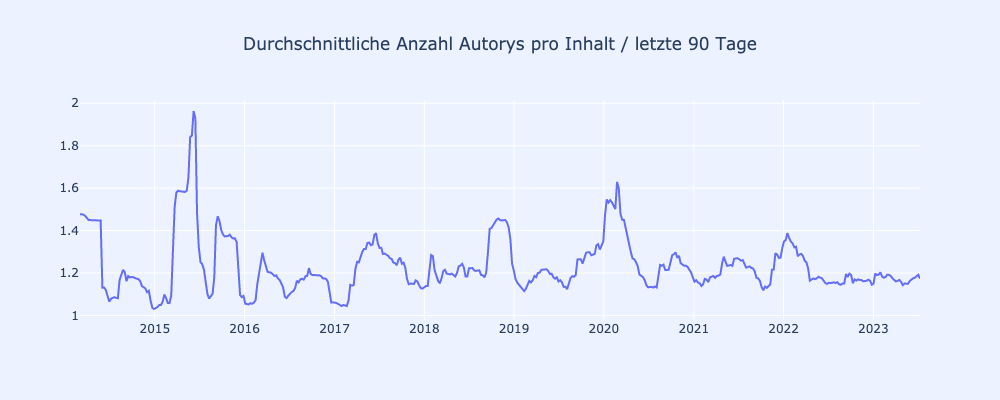

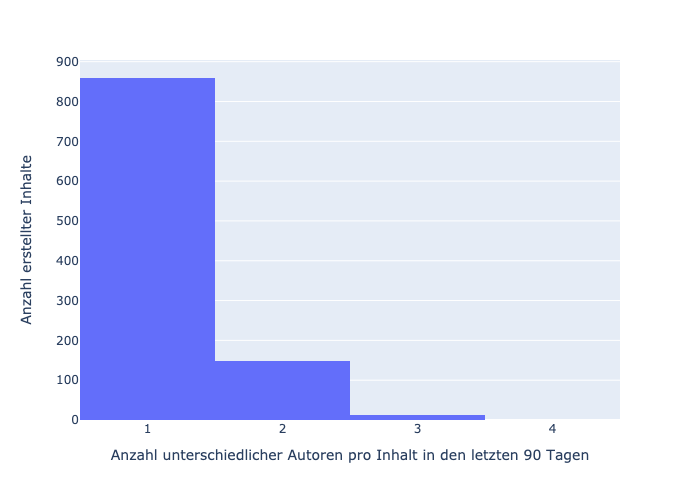

## Durchschnittliche Anzahl Autorys pro erstelltem Inhalt in den letzten 90 Tagen:

## 1.16

## Vor einem Jahr:

## 1.16

## Durchschnittliche Anzahl Autorys aller Inhalte:

## 2.06

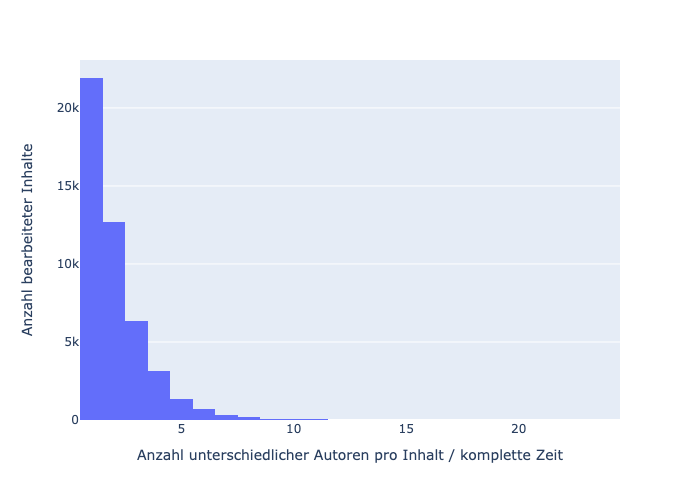

In [42]:
# make_collaboration_plot(timedelta=90, freq="90D")
make_collaboration_plot_contents(delta=90)
# make_collaboration_plot(timedelta=180)
# make_collaboration_plot(timedelta=780)
make_histogram_contents(delta=90)
display(Markdown("## Durchschnittliche Anzahl Autorys pro erstelltem Inhalt in den letzten 90 Tagen:"))
display(Markdown(f"## {round(get_average_number_of_authors_per_content_in_first_days(date = datetime.today() - timedelta(days=90), delta=90), 2)}"))
display(Markdown("## Vor einem Jahr:"))
display(Markdown(f"## {round(get_average_number_of_authors_per_content_in_first_days(date = datetime.today() - timedelta(days=365+90), delta=90), 2)}"))
display(Markdown("## Durchschnittliche Anzahl Autorys aller Inhalte:"))
display(Markdown(f"## {round(get_average_number_of_authors_per_content_in_first_days(), 2)}"))
make_histogram()

# Wann finden (kollaborative) Bearbeitungen statt?

In [43]:
def nth_occurrence(series, n):
    if len(series) >= n:
        return series.iloc[n-1]
    else:
        return None

In [63]:
def make_collaborative_edits_df(date=datetime.today(), delta=None):
    df_1 = df.copy()
    if delta:
        df_1 = df[(df["content_date"] >= date - pd.Timedelta(days=delta)) & (df["content_date"] <= date)]
        df_1 = df_1.loc[df_1['edit_date'] <= df_1['content_date'] + timedelta(days=delta)]
        
    df_filtered = df_1.copy()
    df_filtered = df_filtered.sort_values(by=['edit_date'], ascending=[True])
    df_filtered = df_filtered.loc[df_filtered['collaboration'].isin(['yes'])]
    df_filtered = df_filtered.drop_duplicates(subset=['content_uuid', 'edit_user'], keep='first')
    
    grouped_df_1 = df_filtered.groupby(['content_uuid', 'content_date', 'content_user']).agg(
    first_edit=('edit_date', 'first'),
    second_edit=('edit_date', lambda x: nth_occurrence(x, 2)),
    third_edit=('edit_date', lambda x: nth_occurrence(x, 3)),
    fourth_edit=('edit_date', lambda x: nth_occurrence(x, 4)),
    fifth_edit=('edit_date', lambda x: nth_occurrence(x, 5)),
    sixth_edit=('edit_date', lambda x: nth_occurrence(x, 6)),
    seventh_edit=('edit_date', lambda x: nth_occurrence(x, 7)),
    eighth_edit=('edit_date', lambda x: nth_occurrence(x, 8)),
    ninth_edit=('edit_date', lambda x: nth_occurrence(x, 9)),
    tenth_edit=('edit_date', lambda x: nth_occurrence(x, 10)),
    eleventh_edit=('edit_date', lambda x: nth_occurrence(x, 11)),
    twelfth_edit=('edit_date', lambda x: nth_occurrence(x, 12)),
    thirteenth_edit=('edit_date', lambda x: nth_occurrence(x, 13)),
    fourteenth_edit=('edit_date', lambda x: nth_occurrence(x, 14)),
    fifteenth_edit=('edit_date', lambda x: nth_occurrence(x, 15)),
    sixteenth_edit=('edit_date', lambda x: nth_occurrence(x, 16)),
    seventeenth_edit=('edit_date', lambda x: nth_occurrence(x, 17)),
    eighteenth_edit=('edit_date', lambda x: nth_occurrence(x, 18)),
    nineteenth_edit=('edit_date', lambda x: nth_occurrence(x, 19)),
    twentieth_edit=('edit_date', lambda x: nth_occurrence(x, 20)),
    twenty_first_edit=('edit_date', lambda x: nth_occurrence(x, 21)),
    twenty_second_edit=('edit_date', lambda x: nth_occurrence(x, 22)),
    twenty_third_edit=('edit_date', lambda x: nth_occurrence(x, 23))
    ) 
    
    # Reset index to convert grouped columns into regular columns
    grouped_df_1 = grouped_df_1.reset_index()
    
    columns = [
    'content_date', 'first_edit', 'second_edit', 'third_edit', 'fourth_edit', 'fifth_edit',
    'sixth_edit', 'seventh_edit', 'eighth_edit', 'ninth_edit', 'tenth_edit',
    'eleventh_edit', 'twelfth_edit', 'thirteenth_edit', 'fourteenth_edit',
    'fifteenth_edit', 'sixteenth_edit', 'seventeenth_edit', 'eighteenth_edit',
    'nineteenth_edit', 'twentieth_edit', 'twenty_first_edit',
    'twenty_second_edit', 'twenty_third_edit'
    ]

    for col in columns[1:]:
        grouped_df_1[col] = pd.to_datetime(grouped_df_1[col], infer_datetime_format=True)
        grouped_df_1[col + "_timediff"] = grouped_df_1[col] - grouped_df_1[columns[columns.index(col)-1]]
        
    return grouped_df_1

In [71]:
def make_histogram_df(date=datetime.today(), delta=None):
    df_1 = make_collaborative_edits_df(date=date, delta=delta).copy()
    df_1['first_edit_timediff_bins'] = pd.cut(df_1['first_edit_timediff'], bins=10)
    df_1['first_edit_timediff_bins'] = df_1['first_edit_timediff_bins'].astype('string')
    
    fig = px.histogram(df_1, x='first_edit_timediff_bins')
    fig.show(renderer="png")

In [75]:
def make_histogram_df_2(date=datetime.today(), delta=None):
    df_1 = make_collaborative_edits_df(date=date, delta=delta).copy()
    df_1['first_edit_timediff_bins'] = pd.qcut(df_1['first_edit_timediff'], q=5)
    df_1['first_edit_timediff_bins'] = df_1['first_edit_timediff_bins'].astype('string')
    
    fig = px.histogram(df_1, x='first_edit_timediff_bins')
    fig.show(renderer="png")

In [64]:
def make_quartil_df(date=datetime.today(), delta=None):

        
    columns = ['first_edit_timediff', 'second_edit_timediff', 'third_edit_timediff', 'fourth_edit_timediff', 'fifth_edit_timediff', 'sixth_edit_timediff', 'seventh_edit_timediff', 'eighth_edit_timediff']
    quartiles = ['25%', '50%', '75%', '100%']

    df_edits = pd.DataFrame(index=quartiles)

    for column in columns:
        column_quartiles = make_collaborative_edits_df(date=date, delta=delta)[column].quantile([0.25, 0.5, 0.75, 1])
        df_edits[column] = column_quartiles.values
    df_edits = df_edits.reset_index()
    # print(df_edits)
    
    return df_edits

In [65]:
make_quartil_df()

  index first_edit_timediff      second_edit_timediff  \
0   25%    12 days 18:52:31  158 days 12:25:37.500000   
1   50%   312 days 08:57:04         641 days 05:50:24   
2   75%  1287 days 15:52:57 1479 days 02:59:12.750000   
3  100%  3359 days 18:25:43        3249 days 21:40:55   

        third_edit_timediff     fourth_edit_timediff      fifth_edit_timediff  \
0   97 days 10:54:58.750000         38 days 02:42:15         50 days 02:30:49   
1         487 days 04:52:11 348 days 20:58:32.500000 310 days 06:34:32.500000   
2 1024 days 00:10:03.250000        809 days 20:58:32        769 days 02:19:34   
3        3131 days 00:24:09       2881 days 23:02:50       2744 days 01:42:09   

       sixth_edit_timediff    seventh_edit_timediff     eighth_edit_timediff  
0  41 days 12:32:31.750000  49 days 11:30:43.500000         36 days 12:41:04  
1 268 days 09:14:59.500000 260 days 00:36:12.500000        174 days 02:49:57  
2 744 days 02:54:45.250000        646 days 07:43:49 506 days 03:10:48.5

In [66]:
make_quartil_df(date = datetime.today() - timedelta(days=90), delta=90)

  index    first_edit_timediff    second_edit_timediff    third_edit_timediff  \
0   25% 0 days 07:44:44.500000         1 days 21:42:43 6 days 00:53:08.500000   
1   50%        2 days 03:16:42         2 days 20:26:37       11 days 23:52:58   
2   75% 7 days 14:08:00.500000 30 days 18:02:06.500000       45 days 20:26:43   
3  100%       84 days 20:54:44        81 days 23:37:09       79 days 17:00:28   

  fourth_edit_timediff fifth_edit_timediff sixth_edit_timediff  \
0     59 days 09:31:56                 NaT                 NaT   
1     59 days 09:31:56                 NaT                 NaT   
2     59 days 09:31:56                 NaT                 NaT   
3     59 days 09:31:56                 NaT                 NaT   

  seventh_edit_timediff eighth_edit_timediff  
0                   NaT                  NaT  
1                   NaT                  NaT  
2                   NaT                  NaT  
3                   NaT                  NaT  

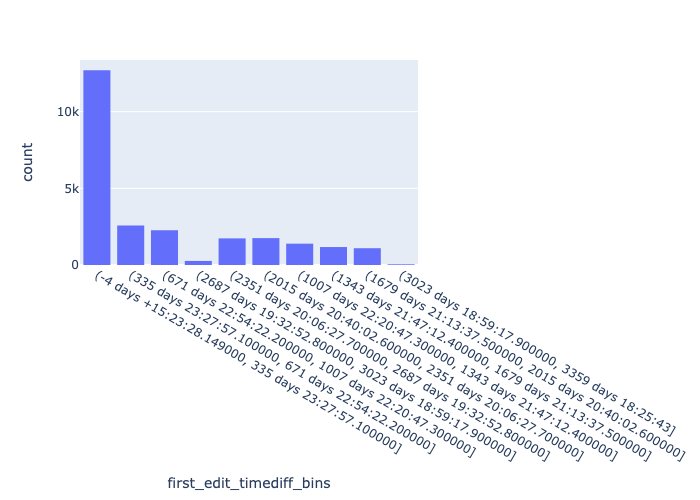

In [72]:
make_histogram_df()

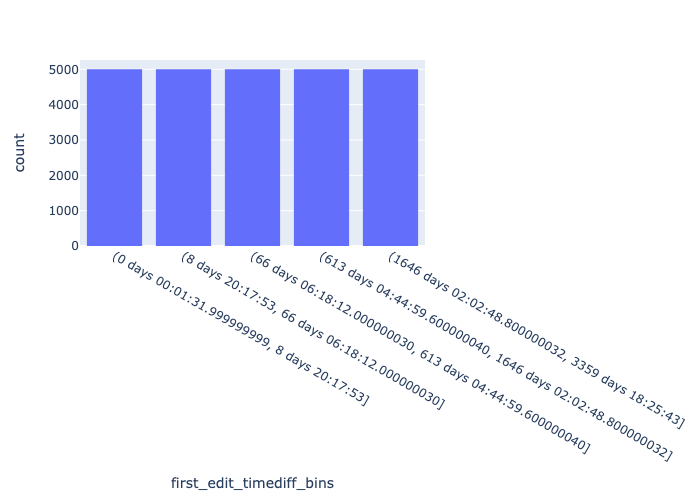

In [76]:
make_histogram_df_2()

# 20% der kollaborativen Bearbeitungen finden innerhalb der ersten 8 Tage nach Inhaltserstellung statt.
# Die nächsten 20% innerhalb der ersten 66 Tage. 
# Die nächsten 20% innerhalb der ersten 613 Tage.
# Usw.

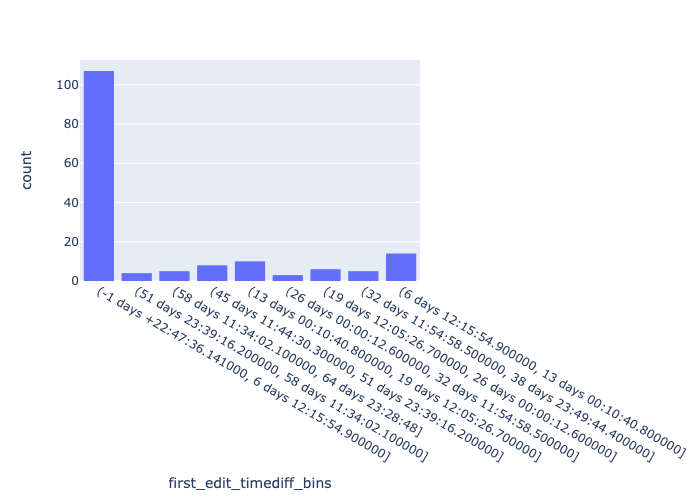

In [73]:
make_histogram_df(delta=90)

# Die meisten kollaborativen Bearbeitungen finden innerhalb der ersten 6 Tage statt.

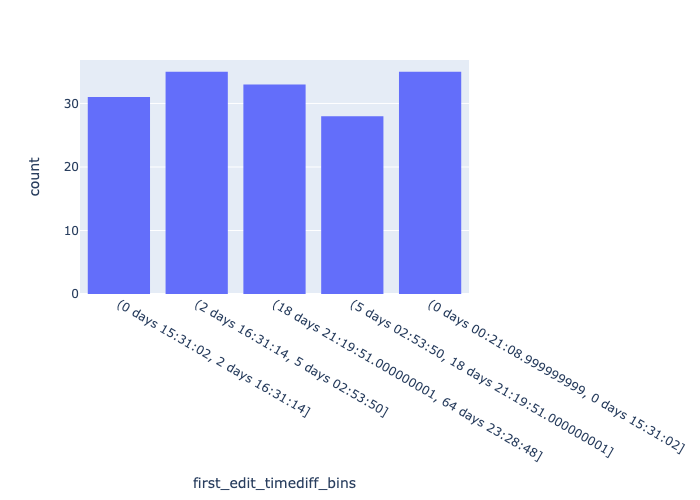

In [77]:
make_histogram_df_2(delta=90)